In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import KFold

In [18]:
# Get the data
df=pd.read_csv("dailyActivity_merged.csv")

# Get information about the data
df.shape
df.columns
df.dtypes

# Clean the data
df['Id'] = df['Id'].astype(str)
df['ActivityDate'] = pd.to_datetime(df['ActivityDate'], format='%m/%d/%Y')

# Get information about the new data
df.shape
df.columns
df.dtypes


Id                                  object
ActivityDate                datetime64[ns]
TotalSteps                           int64
TotalDistance                      float64
TrackerDistance                    float64
LoggedActivitiesDistance           float64
VeryActiveDistance                 float64
ModeratelyActiveDistance           float64
LightActiveDistance                float64
SedentaryActiveDistance            float64
VeryActiveMinutes                    int64
FairlyActiveMinutes                  int64
LightlyActiveMinutes                 int64
SedentaryMinutes                     int64
Calories                             int64
dtype: object

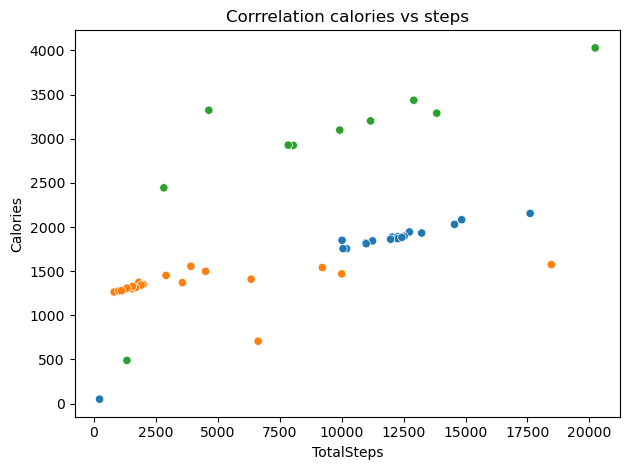

In [19]:
# See if there is a correlation between steps and burnt calories
# Plot the data for some of the IDs
selected_ids = ['1503960366', '1624580081', '1644430081']
df1 = df[df['Id'].isin(selected_ids)]
ax = sns.scatterplot(x='TotalSteps', y='Calories', data=df1, hue=df1['Id'], legend=False)
plt.title('Corrrelation calories vs steps')
plt.tight_layout()

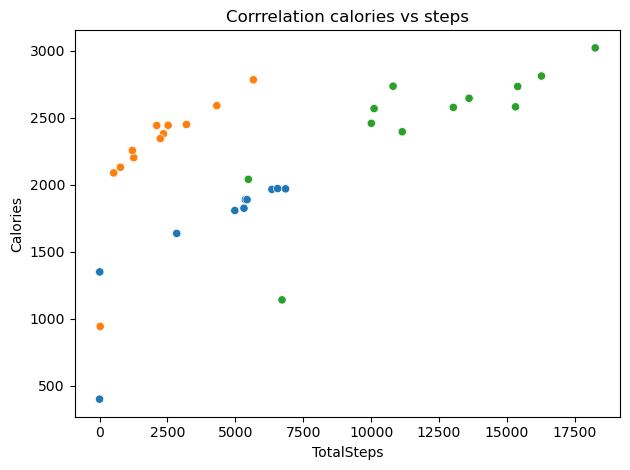

In [20]:
# Plot the data for some other IDs
selected_ids = ['1844505072', '1927972279', '2022484408']
df2 = df[df['Id'].isin(selected_ids)]
ax = sns.scatterplot(x='TotalSteps', y='Calories', data=df2, hue=df2['Id'], legend=False)
plt.title('Corrrelation calories vs steps')
plt.tight_layout()

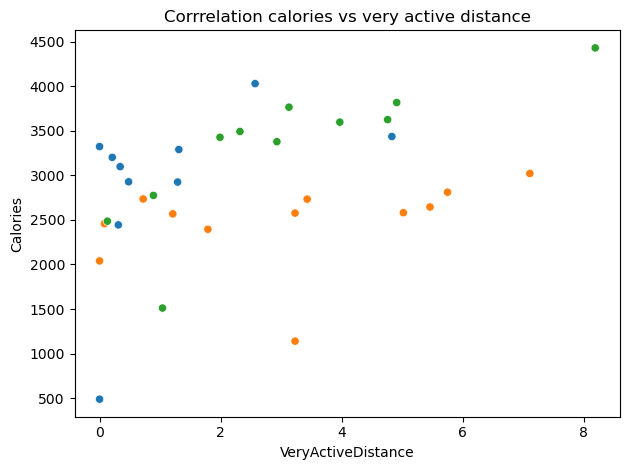

In [21]:
# Plot the data for some other IDs
selected_ids = ['2022484408', '1644430081', '5577150313']
df2 = df[df['Id'].isin(selected_ids)]
ax = sns.scatterplot(x='VeryActiveDistance', y='Calories', data=df2, hue=df2['Id'], legend=False)
plt.title('Corrrelation calories vs very active distance')
plt.tight_layout()

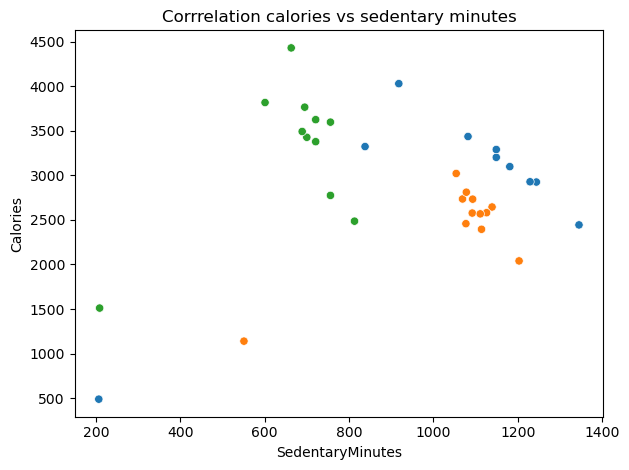

In [22]:
# Plot the data for some other IDs
selected_ids = ['2022484408', '1644430081', '5577150313']
df2 = df[df['Id'].isin(selected_ids)]
ax = sns.scatterplot(x='SedentaryMinutes', y='Calories', data=df2, hue=df2['Id'], legend=False)
plt.title('Corrrelation calories vs sedentary minutes')
plt.tight_layout()

From the plotted data we conclude that the relation between steps and calories is linear

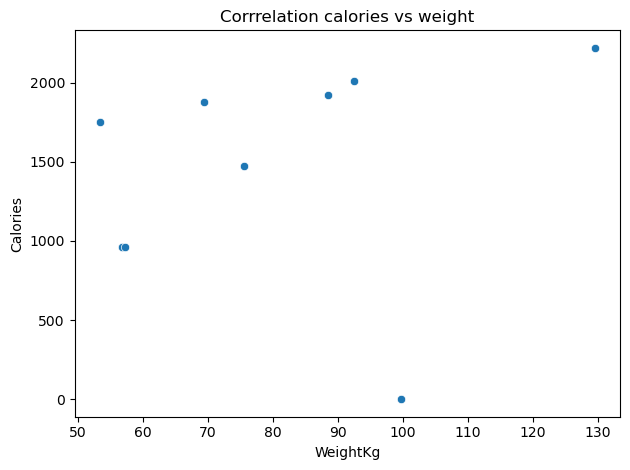

In [5]:
df=pd.read_csv("dailyActivity_merged.csv")
df['Id'] = df['Id'].astype(str)

# See if there is a correlation between weight and averaged calories

# Keep only the days withtout physical activity to have an idea of the resting calories burnt on a rest day
df = df[df['SedentaryMinutes'] > 1200]

# First, compute the average burnt calories
id_grp = df.groupby('Id')
id_avg_cals = id_grp['Calories'].mean()

# Next, load the data from the weight file
df_weight=pd.read_csv("weightLogInfo_merged.csv")
df_weight = df_weight[['Id', 'WeightKg']]
df_weight['Id'] = df_weight['Id'].astype(str)


merged_df = pd.merge(id_avg_cals, df_weight, on='Id')



ax = sns.scatterplot(x='WeightKg', y='Calories', data=merged_df)
plt.title('Corrrelation calories vs weight')
plt.tight_layout()

From this plot we can infere that the calories burnt on a rest day look like log10(0.15 * Weight)

In [15]:
# Load the data
df=pd.read_csv("dailyActivity_merged.csv")
df['Id'] = df['Id'].astype(str)

# Merge the data with the weight
#df_weight=pd.read_csv("weightLogInfo_merged.csv")
#df_weight = df_weight[['Id', 'WeightKg']]
#df_weight['Id'] = df_weight['Id'].astype(str)
#df = pd.merge(df, df_weight, on='Id')

df.shape
df.columns
df.dtypes

# Drop the useless columns
df.drop(columns=['Id' , 'ActivityDate' , 'TrackerDistance', 'LoggedActivitiesDistance'], inplace=True)

# Create the output and drop it from the original matrix
y = df['Calories']
df.drop(columns=['Calories'], inplace=True)

# Convert the matrices to numpy
y = y.to_numpy()
X = df.to_numpy()

# Create a ones column for the offset
X = np.hstack((np.ones((X.shape[0], 1)), X))

def calculate_RMSE(w, X, y):
    y_hat = X @ w
    RMSE = np.sqrt(np.sum((y - y_hat)**2) / len(y))
    return RMSE

def fit(X, y, lam):
    w = np.linalg.inv(X.T @ X + lam * np.identity(X.shape[1])) @ X.T @ y
    return w

lambdas = np.linspace(0,1,1000)
n_folds = 10
RMSE_mat = np.zeros((n_folds, len(lambdas)))

kf = KFold(n_splits=n_folds)
for m , (train_index , test_index) in enumerate(kf.split(X)):
    for n , lam in enumerate(lambdas):
        w = fit(X[train_index],y[train_index],lam)
        RMSE = calculate_RMSE(w,X[test_index],y[test_index])
        RMSE_mat[m][n] = RMSE

avg_RMSE = np.mean(RMSE_mat, axis=0)
lam = lambdas[np.argmin(avg_RMSE)]
print(lam)

w = fit(X , y , lam)
RMSE = calculate_RMSE(w,X[test_index],y[test_index])
print(RMSE)
print(w)

0.32732732732732733
541.2703030479119
[ 7.43537157e+02 -4.16160671e-01  9.24483920e+02 -5.72764487e+02
 -3.05010199e+02 -2.64559173e+02  9.87280683e+01  2.43988381e+01
  5.51682897e+00  1.98249926e+00  6.33382270e-01]


In [ ]:
# Does it work with me?
print(df.columns)
x = np.array([1, 13842, 15.37, 14.62, 0, 0, 0.75, 75, 10, 200, 1155])
print(x @ w)
# Obtained 3905
# Watch expected 3169

x = np.array([1, 23277, 26.19, 22.83, 0, 0, 3.36, 113, 20, 200, 1100])
print(x @ w)
# Obtained 6484
# Watch expected 5027

x = np.array([1, 3522, 2.6, 0.1, 0.8, 0.5, 0.7, 3, 20, 200, 1200])
print(x @ w)
# Obtained 2657
# Watch expected 2350

Index(['TotalSteps', 'TotalDistance', 'VeryActiveDistance',
       'ModeratelyActiveDistance', 'LightActiveDistance',
       'SedentaryActiveDistance', 'VeryActiveMinutes', 'FairlyActiveMinutes',
       'LightlyActiveMinutes', 'SedentaryMinutes'],
      dtype='object')
3905.7257798834944
6484.937801123595
2657.1145903213387
